In [1]:
#import library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
#Import data
df = pd.read_csv('data/titanic.csv', index_col='PassengerId')
df.drop(columns=['Name','Ticket','Cabin'], inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


# Exploratory Data Analysis (EDA)

1. Kondisi target seperti apa
2. Keterhubungan fitur-fitur terhadap target
3. Kategori (ordinal) terhadap target

### Target

In [3]:
df.Survived.value_counts()
#dapat disimpulkan bahwa dalam dataset tersebut lebih banyak yang tidak selamat

0    549
1    342
Name: Survived, dtype: int64

### Numerik vs Target

#### Age vs Survived

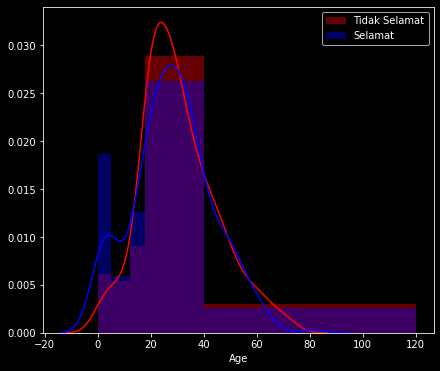

In [4]:
#plot histogramnya, histogram ada bins nya
#bins umur menjadi balita,anak,remaja,dewasa,manula
plt.figure(figsize=(7,6))
sns.distplot(df.Age[df.Survived == 0], bins=[0, 5, 12, 18, 40, 120], color="r", label="Tidak Selamat")
sns.distplot(df.Age[df.Survived == 1], bins=[0, 5, 12, 18, 40, 120], color="b", label="Selamat")
plt.legend();

#dapat disimpulkan bahwa:
#rentang umur 0-5 cenderung "selamat" dan rentang umur dewasa cenderung "tdk selamat"

#### Harga vs Survived

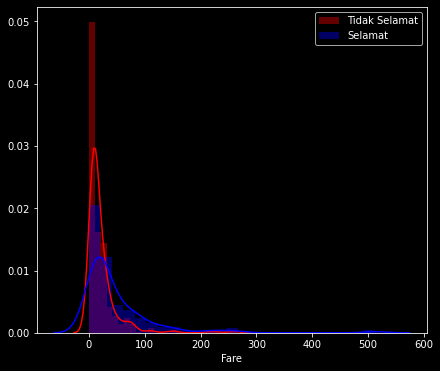

In [5]:
#plot histogramnya, histogram ada bins nya
#bins harga menjadi murah,sedang,tinggi
plt.figure(figsize=(7,6))
sns.distplot(df.Fare[df.Survived == 0], bins=25, color="r", label="Tidak Selamat")
sns.distplot(df.Fare[df.Survived == 1], bins=25, color="b", label="Selamat")
plt.legend();

#dapat disimpulkan bahwa:
#harga dibawah $25(murah) cenderung tidak selamat begitu sebaliknya

### Categorical (Ordinal) vs Target -> count


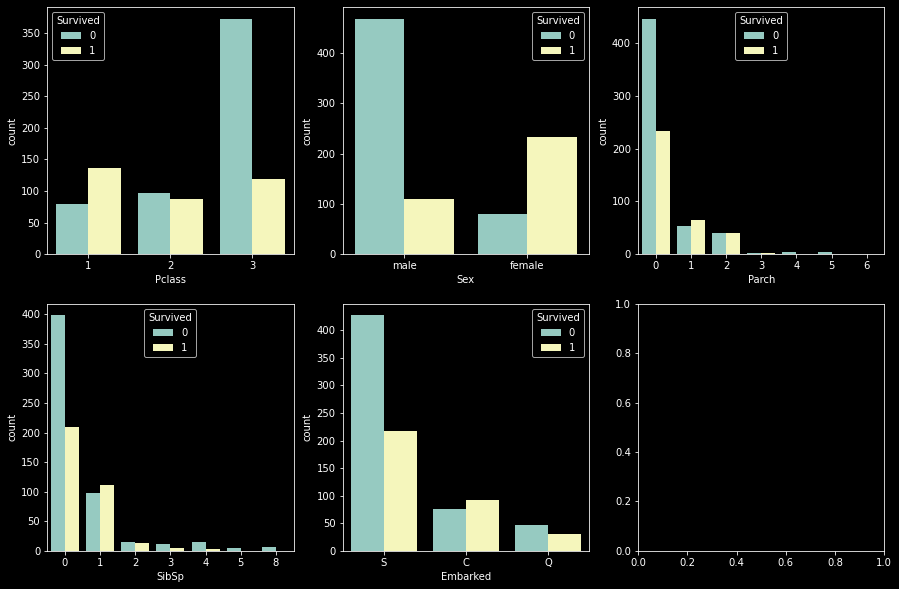

In [6]:
#plot menjadi subplot, karna banyak menggunakan banyak kolom
#0 : tidak selamat, 1:Selamat
cat_var = ["Pclass","Sex","Parch","SibSp","Embarked"]

fig, axes = plt.subplots(2, 3, figsize=(15,10))

for cat, ax in zip(cat_var, axes.flatten()):
    sns.countplot(cat, data=df, hue="Survived", ax=ax)

## Pandas Crosstab 

In [7]:
pd.crosstab(df.Pclass, df.Survived, normalize="index")

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


# Feature Engineering

dimana pada proses ini akan membuat fitur hasil insight yang telah ditemukan

## Adding Feature ==> Is Alone
hasil dari analisis data di atas

In [14]:
df.SibSp == 0

PassengerId
1      False
2      False
3       True
4      False
5       True
       ...  
887     True
888     True
889    False
890     True
891     True
Name: SibSp, Length: 891, dtype: bool

In [15]:
df["isAlone"] = ( df.SibSp == 0) & (df.Parch == 0)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,False
2,1,1,female,38.0,1,0,71.2833,C,False
3,1,3,female,26.0,0,0,7.9250,S,True
4,1,1,female,35.0,1,0,53.1000,S,False
5,0,3,male,35.0,0,0,8.0500,S,True


## Binning
sesuatu yang numerik menjadi categorical. hasil analisis di atas adalah umur dan harga

### Age (Umur)

In [17]:
df.Age = pd.cut(df.Age, [0, 5, 12, 18, 40, 120], labels=["balita","anak","remaja","dewasa","lansia"])
df.head()

TypeError: '<' not supported between instances of 'int' and 'str'

### Fare (Harga)

In [18]:
df.Fare = pd.cut(df.Fare, [0, 25, 100, 600], labels=["murah","mahal","eksekutif"])
df.head()

# df.Fare = pd.cut(df.Fare, [0, 25, 50, 75, 600], labels=["murah","sedang","mahal","eksekutif"])
# df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,murah,S,False
2,1,1,female,dewasa,1,0,mahal,C,False
3,1,3,female,dewasa,0,0,murah,S,True
4,1,1,female,dewasa,1,0,mahal,S,False
5,0,3,male,dewasa,0,0,murah,S,True


# Kombinasi jcopml dan Scikit-learn

## Dataset Splitting

In [19]:
#Dataset Splitting
X = df.drop(columns="Survived")
y = df.Survived #target (lable)

#splitting 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712,), (179,))

## Preprocessor

In [8]:
#membantu dalam membuat pipeline menjadi lebih simple
from jcopml.pipeline import num_pipe, cat_pipe

In [9]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [20]:
#memisahkan kolom mana yg masuk ke numeric atau categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(scaling="minmax"), ["SibSp","Parch"]),
    ("categoric",cat_pipe(encoder="onehot"), ["Pclass","Sex","Embarked","Fare","Age","isAlone"])
])
#----------------------------------------------------------------------------------------------------------------#

## Training

In [21]:
#untuk optimasi dari package jcopml
from jcopml.tuning import grid_search_params as gsp

In [22]:
#rekomendasi yang harus dipakai 
gsp.knn_params

{'algo__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
 'algo__weights': ['uniform', 'distance'],
 'algo__p': [1, 1.5, 2]}

In [23]:
#Pipeline
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])
#----------------------------------------------------------------------------------------------------------------#

##membuat gridcv >> cv=CrossValidation
model = GridSearchCV(pipeline,gsp.knn_params, cv=3, n_jobs=-1, verbose=1)
#----------------------------------------------------------------------------------------------------------------#

##training
model.fit(X_train, y_train)
#----------------------------------------------------------------------------------------------------------------#

#Evaluation
##melihat model mana yang terbaik
print(model.best_params_)


##Melihat overfit atau underfit >> train-val-test score >> mendapatkan "model prediksi"
print(model.score(X_train,y_train), model.best_score_, model.score(X_test,y_test))

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.0s
{'algo__n_neighbors': 25, 'algo__p': 2, 'algo__weights': 'distance'}
0.8792134831460674 0.8146237397912751 0.7988826815642458
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   11.4s finished
